In [7]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn import cluster
from sklearn.preprocessing import scale
from uszipcode import ZipcodeSearchEngine
from shapely.geometry import Point
import geojson
import json
import pickle
import folium
from folium import plugins
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set(style="whitegrid")

In [8]:
# read in cleaned rentals data as geodataframe
data = pd.read_csv("cleaned_data_final.csv")
# convert latitude and longitude points into GIS data points
geometry = [Point(xy) for xy in zip(data['geocode_lon'], data['geocode_lat'])]
# set projections for geometry 
crs = {'init': 'epsg:4326'}
locations = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)
locations = locations.to_crs({'init': 'epsg:4326'})

In [9]:
# create geodataframe of zipcodes of Minnesota
zipcodes = gpd.GeoDataFrame.from_file('zip_code_tabulation_areas.shp')
# set projection of zipcodes
zipcodes = zipcodes.to_crs({'init': 'epsg:4326'})
# rename column of minnesota zipcodes file
zipcodes = zipcodes.rename(columns={'GEOID10': 'zipcodes'})
# perform spatial join between craigslist 
loc_zip_join = gpd.sjoin(locations, zipcodes, how="left", op='within')
# re-size dataframe to only include necessary columns
final_df = loc_zip_join[['address', 'beds boolean', 'beds_baths', 'county', 'county_full', 'datetime', 'geocode_lat', 'geocode_lon', 'post id', 'price', 'price boolean', 'square feet', 'square feet boolean', 'title', 'url', 'County', 'City', 'bed assigned', 'no match', 'index match', 'outlier', 'zipcodes']]

Fair market rents data for Twin Cities 2018 https://www.huduser.gov/portal/datasets/fmr/fmrs/FY2018_code/2018summary.odn

In [10]:
# create dictionary of the fair market rents of the Twin Cities according to 
fmr_dict = {"studio" : 711, "1" : 864, "2" : 1089, "3" : 1547, "4" : 1812}
# function to determine how many standard deviations over or under fmr rent is 
def over_fmr(df, col_name, std_dictionary, fmr_dictionary, std_list):
    # define crunch_fmr to calculate if price is over threshold for given standard deviation
    def crunch_fmr(beds, **kwargs):
    # get standard deviation for given beds value, add it to fmr value, multiply it by number of standard deviations
        return float(fmr_dictionary.get(beds)) + (float(std_dictionary.get(beds)) * float(standard_deviation))
    # loop through list of std 1-3
    for standard_deviation in std_list:
        # new column for each standard deviation threshold
        std_column_name = "over fmr" + str(standard_deviation)
        df[std_column_name] = 0
        # apply crunch_fmr
        df.loc[(df[col_name] > df['beds_baths'].apply(crunch_fmr, fmr_dictionary=fmr_dictionary, std_dictionary = std_dictionary, threshold = standard_deviation)), std_column_name] = 1
    return df  

In [11]:
# pickle filenames
filenames = ['sqft_std_dict.pickle', 'sqft_mean_dict.pickle', 'price_mean_dict.pickle', 'price_std_dict.pickle']
# function to import pickle files as dictionaries with standard deviations and means for prices and square feet data
def pickle_to_dict(filenames):
    dictionaries_list = []
    for file in filenames:
        with open(file, 'rb') as handle:
            unserialized_data = pickle.load(handle)
            dictionaries_list.append(unserialized_data)
    return dictionaries_list
# run function to save dictionaries for use in a later script
sqft_std_dict, sqft_mean_dict, price_mean_dict, price_std_dict = pickle_to_dict(filenames)


In [12]:
# list of values 1, 2, 3 for standard deviations
std_list = [1, 2, 3]
# run over_fmr function to create dataframe with booleans of rentals 1, 2, 3 standard deviations over fmr
df_vals_over_fmr = over_fmr(final_df, 'price', price_std_dict, fmr_dict, std_list)
# save dataframe with over_fmr attributes
df_vals_over_fmr.to_csv('over_fmr_dataframe.csv')

C:\Users\murra667\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\murra667\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [13]:
# copy dataframe as df_vals_over_fmr will be modified
final_zipcodes = df_vals_over_fmr
#convert studio to one in order to sum number of craigslist units per zip code
df_vals_over_fmr.loc[df_vals_over_fmr['beds_baths'] == "studio", "beds_baths"] = "1"
# convert beds_baths to float
df_vals_over_fmr['beds_baths'] = df_vals_over_fmr['beds_baths'].astype(float)
# sum number of beds baths in zipcodes
beds_per_zip_craigslist = df_vals_over_fmr.groupby('zipcodes')['beds_baths'].sum()
# reset index of dataframe and rename columns
beds_per_zip_craigslist = beds_per_zip_craigslist.reset_index()
beds_per_zip_craigslist = beds_per_zip_craigslist.rename(columns={'beds_baths': 'craigslist beds per zip'})
beds_per_zip_craigslist


C:\Users\murra667\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\murra667\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,zipcodes,craigslist beds per zip
0,55101,725.0
1,55102,179.0
2,55103,73.0
3,55104,348.0
4,55105,131.0
5,55106,224.0
6,55107,66.0
7,55108,523.0
8,55109,73.0
9,55110,96.0


Documentation For uszipcode library https://pythonhosted.org/uszipcode/

In [14]:
# function to perform operations on dataframes 
# for 1,2,3 standard deviations over fmr
def munge_over_fmr(dfs, df_beds_sum):
    dataframes = []
    for dataframe in dfs:
        # sum the number of units over fmr
        over_fmr_sum = dataframe.groupby('zipcodes')['beds_baths'].sum()
        # reindex dataframe
        over_fmr_craigslist = over_fmr_sum.reset_index()
        over_fmr_craigslist = over_fmr_craigslist.rename(columns={'beds_baths': 'craigslist beds per zip over fmr'})
        # merge dataframe sums of craigslist per zipcode and sums of overfmr listings per zipcode
        merged = pd.concat(objs = [df_beds_sum.set_index('zipcodes'), over_fmr_craigslist.set_index('zipcodes')], axis = 1)
        # create zipcodes column
        merged['zipcodes'] = merged.index
        # create columns of new information from US Census from ZipcodeSearchEngine
        for index, row in merged.iterrows():
            # call zipcode search engine
            search = ZipcodeSearchEngine()
            # input each zipcode from dataframe into search engine
            zipcode=search.by_zipcode(row['zipcodes'])
            # get total number of units per zipcode according to census
            units_tot = zipcode.HouseOfUnits
            # get wealth rating of zipcode
            wealth = zipcode.Wealthy
            # create columns of total units and wealth in dataframe
            merged.loc[index, 'total units'] = units_tot
            merged.loc[index, 'wealth'] = wealth
        # reindex dataframe
        index_list = list(range(len(merged.index)))
        # make index series a column in dataframe
        merged['index'] = index_list
        # set index column as index of dataframe
        merged = merged.set_index(['index'])
        # fill na
        merged = merged.fillna(0)
        # coerce columns
        merged['total units'] = pd.to_numeric(merged['total units'], errors = "coerce")
        merged['craigslist beds per zip'] = pd.to_numeric(merged['craigslist beds per zip'], errors = "coerce")
        merged['craigslist beds per zip over fmr'] = pd.to_numeric(merged['craigslist beds per zip over fmr'], errors = "coerce")
        merged['wealth'] = pd.to_numeric(merged['wealth'].astype(float), errors = "coerce")
        # calculate percent of craigslist listings per total units in zipcode
        merged['craigslist pct per total units'] = 0
        # cast column as float
        merged['craigslist pct per total units'] = merged['craigslist pct per total units'].astype(float)
        # calculate column craigslist pct per total units which tries to estimate how many units per zipcode
        # are available on craigslist
        merged['craigslist pct per total units'] = merged['craigslist beds per zip'].div(merged['total units'])
        # percent of craigslist listings x standard deviations over fmr 
        merged['craigslist pct over fmr'] = 0 
        # cast as float
        merged['craigslist pct over fmr'] = merged['craigslist pct over fmr'].astype(float)
        # percent of craigslist listings per craigslist total in zip code
        merged['craigslist pct over fmr'] = merged['craigslist beds per zip over fmr'].div(merged['craigslist beds per zip'])
        # attempt to calculate measure of wealth and unaffordability
        merged['normalized measure of over fmr'] = merged['craigslist pct over fmr'] * merged['craigslist pct per total units']
        # calculate percent of craigslist data per zipcode
        merged['pct of listings by craigslist population'] = merged['craigslist beds per zip'].div(19240)
        # calculate the mean weatlh number
        wealth_median = np.median(merged['wealth'])
        # create boolean of above and below average wealth 
        merged['above median'] = False
        merged.loc[merged['wealth'] > wealth_median, 'above median'] = True
        dataframes.append(merged)
    return dataframes

In [15]:
# sum of over fmr units per zipcode house of units
over_fmr_1 = df_vals_over_fmr.loc[df_vals_over_fmr['over fmr1'] == 1]
over_fmr_2 = df_vals_over_fmr.loc[df_vals_over_fmr['over fmr2'] == 1]
over_fmr_3 = df_vals_over_fmr.loc[df_vals_over_fmr['over fmr3'] == 1]
# create list of dataframes with over fmr rows
dfs = [over_fmr_1, over_fmr_2, over_fmr_3]
# munge dataframes 
munged1, munged2, munged3 = munge_over_fmr(dfs, beds_per_zip_craigslist)
munged_list = [munged1, munged2, munged3]
# save munged dataframes to csvs
for df_munged in munged_list:
    count = 1
    df_munged.to_csv('craigslist_munged' + str(count) + '.csv')
    count += 1

C:\Users\murra667\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  if sys.path[0] == '':


In [16]:
zipcodes = gpd.GeoDataFrame.from_file('zip_code_tabulation_areas.shp')
# set projection of zipcodes
zipcodes = zipcodes.to_crs({'init': 'epsg:4326'})
# rename column of minnesota zipcodes file
zipcodes = zipcodes.rename(columns={'GEOID10': 'zipcodes'})

In [17]:
# subset minnesota zipcodes
# so as to match those containing craigslist rental ads
# in ramsey and hennepin county
# merge zipcodes spatial data with munged dataframe
choropleth_input = zipcodes.merge(munged1, on='zipcodes')
# create json
choropleth_json = choropleth_input.to_json()
datastore = json.loads(choropleth_json)


In [27]:
# define function to map each over fmr dataframe
def map_fmrs(json, dataframes):
    count = 1
    column = "over_fmr"
    for dataframe in dataframes:
        # create map object
        fmr_map = folium.Map(location=[44.986656, -93.258133], zoom_start=12)
        # create choropleth map
        fmr_map.choropleth(geo_data = json, data = dataframe,
                 columns=['zipcodes', 'craigslist pct over fmr'],
                 key_on='feature.properties.zipcodes',
                 legend_name = 'Percent of Craigslist Listings ' + str(count) + ' Standard Deviation Over FMR By Zipcode', fill_opacity=.8, line_opacity=.9,
                 fill_color='OrRd')
        # save maps
        fmr_map.save('overfmr' + str(count) + '.html')
        count += 1

In [28]:
# list of munged datasets to input into function
munged_dataframes = [munged1, munged2, munged3]
map_fmrs(datastore, munged_dataframes)



In [20]:
# create map
m = folium.Map(location=[44.986656, -93.258133], zoom_start=12)
# convert to (n, 2) nd-array format for heatmap
heat_points = final_df[['geocode_lat', 'geocode_lon']].as_matrix()
# convert heatpoints to list
heat_points = heat_points.tolist()
# plot heatmap
m.add_child(plugins.HeatMap(heat_points, radius=10))
m.save('craigslist_listings.html')

C:\Users\murra667\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [21]:
# function to 
def quartiles_heatmap(quartiles):
    count = 1
    for q in quartiles:
        # create map
        m = folium.Map(location=[44.986656, -93.258133], zoom_start=12)
        # convert to (n, 2) nd-array format for heatmap
        heat_points = q[['geocode_lat', 'geocode_lon']].as_matrix()
        # convert heatpoints to list
        heat_points = heat_points.tolist()
        # plot heatmap
        m.add_child(plugins.HeatMap(heat_points, radius=10))
        m.save('q' + str(count) + '.html')
        count += 1

In [22]:
# create quartiles of price data
twentyfifth, fiftieth, seventyfifth, hundred = np.percentile(df_vals_over_fmr['price'], [25, 50, 75, 100])
# create subsets of each quartile
q1 = df_vals_over_fmr.loc[(df_vals_over_fmr['price'] <= twentyfifth)]
q2 = df_vals_over_fmr.loc[(df_vals_over_fmr['price'] > twentyfifth) & (df_vals_over_fmr['price'] <= fiftieth)]
q3 = df_vals_over_fmr.loc[(df_vals_over_fmr['price'] > fiftieth) & (df_vals_over_fmr['price'] <= seventyfifth)]
q4 = df_vals_over_fmr.loc[(df_vals_over_fmr['price'] > seventyfifth) & (df_vals_over_fmr['price'] <= hundred)]
# set quartiles list
quartiles = [q1, q2, q3, q4]
# call create_heatmap
quartiles_heatmap(quartiles)

C:\Users\murra667\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


## Data Storytelling

## Questions Asked

1. Where are craigslist housing rental ads distributed throughout Hennepin and Ramsey Counties?
2. Using craigslist housing rental ads as a proxy, and HUD Fair Market Rents as a threshold for affordability, what are the spatial patterns of affordability in Hennepin and Ramsey Counties?
3. What is the relationship between square feet and price?
4. How is the data distributed across price variables?

## Trends Investigated 
1. Density of craigslist housing rental ads in Hennepin and Ramsey Counties
2. Spatial clustering of affordable housing by zipcode in Hennepin and Ramsey Counties
3. Correlation between Square feet and Price variables
4. The spread of the price data

## Plot the Prices Distribution

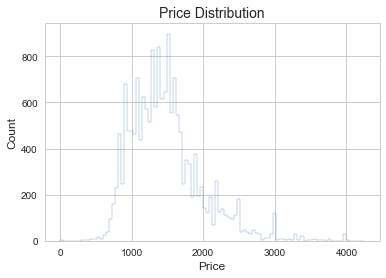

In [23]:
data = pd.read_csv("cleaned_data_final.csv")
# plot prices to see what the distribution looks like
_ = plt.hist(data['price'], bins = 100, histtype = 'step')
plt.xlabel('Price', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Price Distribution', fontsize=14)
plt.show()

The price distribution for all listings is skewed right, and the center hovers around 1500-1700 dollars per month. This is irrespective of the Studio, 1, 2, 3 or 4 bedroom groupings. The maxmimum price for a listing is slightly above 4000 per month. 

## Analyze The Price Distribution Across Bed Groupings

C:\Users\murra667\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


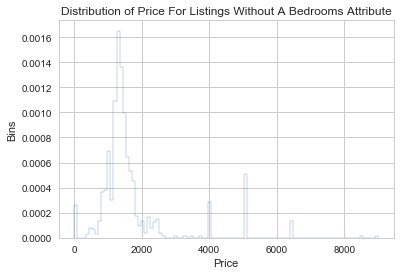

In [24]:
# import pickle file containing bed values that were unassigned
unassigned_beds = pd.read_pickle('unassigned_beds.pickle', compression = "infer")
# limit to price column
unassigned_beds['price'] = unassigned_beds['price'].astype(float)
# drop clear outliers from unassigned beds
unassigned_beds = unassigned_beds.loc[unassigned_beds['price'] < 10000] 
unassigned_beds = unassigned_beds['price']
# visualize distribution of unassigned beds to look for patterns
_ = plt.hist(unassigned_beds, bins = 100, normed=True, histtype = 'step')
plt.xlabel("Price")
plt.ylabel("Bins")
plt.title("Distribution of Price For Listings Without A Bedrooms Attribute")
plt.show()

Rental data obtained through craigslist presented the challenge of discerning user inputs in the number of bedrooms variable, or the lack of thereof, and what bedroom classification was truly meant for the ad. 

Above is the distribution of prices for listings where no bedroom type was specified anywhere in the listing by the user. Potential reasons for not specifying a bedrooms attribute could have been 1) the listing was for a physical bedroom space available in a multi-bedroom unit, or a studio apartment, both conditions that the user is not able to specify with the values allowed by craigslist 2) the user simply did not specify bedrooms unrelated to the formerly stated possibilities. The distribution is normal, suggesting that there was no one bed grouping that is overrepresented in not containing a bed attribute specified by the user somewhere in the listing. This seems to outrule possibility 1), suggesting possibility 2) may be behind the unlabeled listings

C:\Users\murra667\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


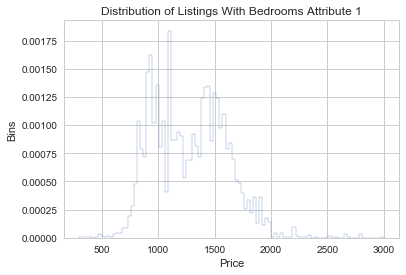

In [25]:
# import dataframe containing column on properties over fair market rent
over_fmr = pd.read_csv("over_fmr_dataframe.csv")
# subset beds that were assigned one to take a closer look
one_bed = over_fmr.loc[over_fmr['beds_baths'] == "1"]
#plot_df = updated_df_clean.loc[updated_df_clean['no match'] == True]
#print (len(plot_df))
_ = plt.hist(one_bed['price'], bins = 100, normed=True, histtype = 'step')
plt.xlabel("Price")
plt.ylabel("Bins")
plt.title("Distribution of Listings With Bedrooms Attribute 1")
plt.show()

The distribution for listings with a bedrooms attribute of "1" was plotted to examine if there is more than one cluster of price values among this category of listings. In listings where the user specified "1" as the bedroom attribute, the listing may have been for an actual 1 bedroom apartment, one single bedroom in a multi-bedroom living situation, or a studio apartment - since there is no option for users to classify the latter two on craigslist. The distribution does have some characteristics of a bi-modal distribution. Assuming that 1 bedroom rentals are more expensive than studio bedrooms, it is possible that the lower values represent listings of studio apartements, and the higher values, 1 bedroom apartements. A test of normality is performed on this distribution in Inferential Statistics. 


## Maps

As can be seen in __[A Heatmap of Craigslist Housing Rental Ads in the Twin-Cities](https://raw.githubusercontent.com/murra667/Data-Storytelling/master/craigslist_listings.html)__, the density of listings tends to cluster in Minneapolis and St. Paul, specifically in the central business districts of these cities. Listings are also prominent in the Uptown, UM-TC campus neighborhoods of Minneapolis. In addition, there appear to be addresses throughout Hennepin and Ramsey County that generate their own heat spot, meaning that there are multiple listings in the dataset at this precise location. This could indicate that 1) There are duplicate listings in the dataset that had different post ids (likely re-posted on a different day or at a different time) 2) Specific properties in the dataset use craigslist for most of their advertising and so have multiple ads at a time from one building or property on craigslist. 


As can be seen in __[Ads 1 Standard Deviation Above the Twin-Cities Fair Market Rent per Zipcode](https://github.com/murra667/Data-Storytelling/raw/master/overfmr1.html)__, zipcodes in which 80-100% of ads are one standard deviation over the fair market rent are located in the central business districts of Minneapolis an St. Paul. The zipcode encompassing most of the City of Columbia Heights in Henenpin County is also in this range of unaffordability. Other Cities and/or areas of Minneapolis that seem unaffordable are the City of St. Louis Park, Edina and Uptown/ Southwest Minneapolis. Overall, Ramsey County seems to have less zipcodes that have high percentages of listings over the fair market rent Future analysis may be done with the wealth attribute of these zipcodes.

In the __[Ads 2 Standard Deviation Above the Twin-Cities Fair Market Rent per Zipcode](https://github.com/murra667/Data-Storytelling/raw/master/overfmr2.html)__ map, the central business district of Minneapolis continues to have the highest percentage of unaffordable craigslist listings, with 70-80% two standard deviations over the Twin-Cities Fair Market Rent. Areas such as the Uptown neighborhood and City of St. Louis Park also have high percentages. Interestingly, Columbia Heights, where 80-100% of listings in this zipcode are at least one standard deviation over the fair market rent, has nearly disappeared from the map, as have many zipcodes in St. Paul and Ramsey County. 

In the __[Ads 3 Standard Deviation Above the Twin-Cities Fair Market Rent per Zipcode](https://github.com/murra667/Data-Storytelling/raw/master/overfmr3.html)__ map, the downtown Minneapolis continues to have the highest percentage of listings over the fair market rent, somewhere between 37-45%. Specifically, this is the zipcode that encompasses Downtown East, an area that has undergone significant development in the past 3 years. Adjacent to here, in the zipcode containing the North Loop neighborhood, the second highest percentage, 15-22% of listings are more than 3 standard deviations about the Fair Market Rent.


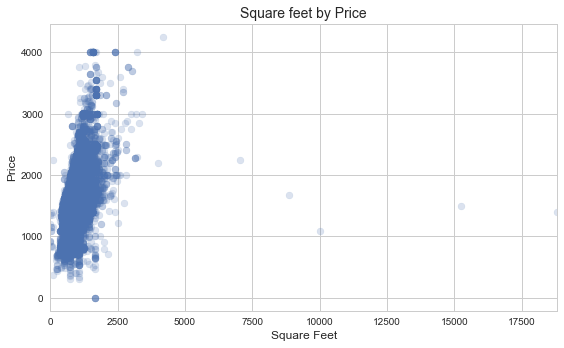

In [26]:
# generate a scatterplot for price vs square feet 
# and create lists as inputs
x = [a for a in data['square feet']]
y = list(data['price'])
# generate plot object
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)
# set plot configurations
ax.set_xlim([0, max(x)])
ax.set_xlabel('Square Feet', fontsize=12)
ax.set_ylabel('Price', fontsize=12)
ax.set_title('Square feet by Price', fontsize=14)
# set plot layout
ax.grid(True)
fig.tight_layout()
plt.show()

The scatterplot below suggests a strong relationship between Square Feet and Price, with almost all rentals, regardless of price, under 2500 square feet. 

## Conclusions


Overall, issues for further analysis are the differences in affordability between Minneapolis and St. Paul or Hennepin and Ramsey County, the differences in affordability between suburban cities of the two main cities St. Paul and Minneapolis, the clustering of craigslist ads in certain corridors of Minneapolis and at precise address locations, and normality of the distribution of listings labeled as 1 bedroom.
